# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_186  Q9BY67-2         19.394
Sample_034  Q9NYX4           16.531
Sample_130  Q9Y6Y9           13.585
Sample_138  A0A075B6K5       17.404
Sample_209  P35542           19.443
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                   
Sample_183  E9PK25;G3V1A4;P23528                                14.653
Sample_113  E7EN65;E7ENM0;P15502-1;P15502-2;P15502-4;P15502-5   15.001
Sample_050  O95841                                              14.109
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.364
            A0A075B6Q5                 11.957
            A0A075B6R2                 14.025
            A0A075B6S5                 13.402
            A0A087WSY4                 11.728
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.478
            Q9UI40;Q9UI40-2            11.599
            Q9UIW2                     13.208
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.187
            Q9UP79                     11.526
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.938,15.050,16.842,19.863,15.614,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.470,19.067,...,15.528,15.576,14.252,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.641,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.595,17.705,17.039,16.395,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.682,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.706,15.345,17.084,18.708,14.249,19.433,12.314,10.943
Sample_207,15.739,16.877,15.469,16.898,14.994,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.364,...,16.012,15.178,12.224,15.050,16.842,19.863,14.022,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.309,19.067,16.188,...,15.528,15.576,11.739,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.011,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.844,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.089,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.377,15.345,17.084,18.708,14.249,19.433,10.584,13.013
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 388.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.31it/s]

100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.88it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.56it/s]

100%|██████████| 4/4 [00:00<00:00,  4.04it/s]

100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.16it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.57it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.99it/s]

100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.17it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.16it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.78it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.02it/s]

100%|██████████| 6/6 [00:01<00:00,  2.53it/s]

100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.15it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.83it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.45it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.27it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.35it/s]

100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.47it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.68it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.70it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.72it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.76it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.77it/s]

100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.37it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.54it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.37it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.25it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.27it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.32it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.30it/s]

100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

100%|██████████| 9/9 [00:02<00:00,  3.35it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.74it/s]

 30%|███       | 3/10 [00:00<00:02,  3.40it/s]

 40%|████      | 4/10 [00:01<00:01,  3.07it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.02it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.16it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.20it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.25it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.98it/s]

100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.09it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.50it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.92it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.65it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.78it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.45it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.29it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.19it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.19it/s]

100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.58it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.63it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.04it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.40it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.07it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.04it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.14it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.28it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.41it/s]

100%|██████████| 12/12 [00:04<00:00,  2.56it/s]

100%|██████████| 12/12 [00:04<00:00,  2.48it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.88it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.70it/s]

 31%|███       | 4/13 [00:01<00:04,  2.18it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.01it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.95it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.17it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.27it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.37it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.48it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.57it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.64it/s]

100%|██████████| 13/13 [00:05<00:00,  2.66it/s]

100%|██████████| 13/13 [00:05<00:00,  2.45it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.58it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.47it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.02it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.99it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.04it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.04it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.14it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.17it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.35it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.51it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.67it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.74it/s]

100%|██████████| 14/14 [00:05<00:00,  2.60it/s]

100%|██████████| 14/14 [00:05<00:00,  2.37it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  3.14it/s]

 20%|██        | 3/15 [00:01<00:05,  2.33it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.28it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.15it/s]

 40%|████      | 6/15 [00:02<00:04,  2.16it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.31it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.32it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.23it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.26it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.09it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.23it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.59it/s]

100%|██████████| 15/15 [00:06<00:00,  2.65it/s]

100%|██████████| 15/15 [00:06<00:00,  2.38it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.050 0.013          0.877 0.207       0.167   
2             0.004 0.004      0.059 0.029          0.657 0.103       0.570   
3             0.005 0.004      0.065 0.030          0.658 0.120       0.583   
4             0.008 0.008      0.098 0.037          0.712 0.101       0.636   
5             0.006 0.005      0.086 0.030          0.758 0.088       0.798   
6             0.007 0.006      0.083 0.031          0.782 0.093       0.817   
7             0.007 0.006      0.073 0.031          0.783 0.093       0.825   
8             0.007 0.006      0.090 0.042          0.793 0.085       0.829   
9             0.009 0.010      0.095 0.049          0.790 0.089       0.827   
10            0.007 0.006      0.089 0.034          0.794 0.084       0.820   
11            0.007 0.006      0.085 0.038          0.786 0.086       0.819   
12            0.006 0.004      0.079 0.032          0.795 0.080       0.812   
13            0.007 0.006      0.079 0.032          0.781 0.084       0.808   
14            0.006 0.004      0.067 0.028          0.779 0.080       0.805   
15            0.007 0.006      0.072 0.029          0.782 0.084       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.092   0.270 0.129                  0.575 0.045        0.858   
2          0.104   0.604 0.084                  0.674 0.062        0.729   
3          0.127   0.609 0.106                  0.676 0.078        0.765   
4          0.117   0.663 0.083                  0.719 0.064        0.807   
5          0.109   0.772 0.076                  0.804 0.065        0.887   
6          0.112   0.794 0.078                  0.823 0.068        0.889   
7          0.104   0.799 0.076                  0.827 0.066        0.886   
8          0.106   0.806 0.073                  0.834 0.063        0.907   
9          0.106   0.803 0.073                  0.831 0.063        0.905   
10         0.104   0.802 0.070                  0.831 0.060        0.904   
11         0.105   0.797 0.071                  0.826 0.061        0.902   
12         0.094   0.799 0.067                  0.828 0.058        0.909   
13         0.094   0.791 0.068                  0.820 0.058        0.909   
14         0.096   0.788 0.069                  0.818 0.058        0.908   
15         0.099   0.790 0.070                  0.819 0.061        0.906   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.827 0.087        210.000 0.000  
2          0.073                  0.662 0.089        210.000 0.000  
3          0.073                  0.692 0.093        210.000 0.000  
4          0.063                  0.769 0.084        210.000 0.000  
5          0.050                  0.860 0.063        210.000 0.000  
6          0.049                  0.862 0.059        210.000 0.000  
7          0.052                  0.857 0.063        210.000 0.000  
8          0.050                  0.893 0.055        210.000 0.000  
9          0.050                  0.893 0.055        210.000 0.000  
10         0.051                  0.891 0.056        210.000 0.000  
11         0.052                  0.888 0.057        210.000 0.000  
12         0.049                  0.902 0.049        210.000 0.000  
13         0.050                  0.902 0.050        210.000 0.000  
14         0.049                  0.901 0.049        210.000 0.000  
15         0.049                  0.899 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 469.63it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.81it/s]

100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.70it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.57it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.55it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.43it/s]

100%|██████████| 5/5 [00:01<00:00,  2.48it/s]

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.32it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.47it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.04it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  2.95it/s]

100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.51it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.01it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.34it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.15it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.07it/s]

100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.28it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.72it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.35it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.84it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.34it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.11it/s]

100%|██████████| 8/8 [00:03<00:00,  1.87it/s]

100%|██████████| 8/8 [00:03<00:00,  2.36it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.92it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.03it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.33it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.06it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.97it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.07it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.15it/s]

100%|██████████| 9/9 [00:04<00:00,  1.91it/s]

100%|██████████| 9/9 [00:04<00:00,  2.16it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  2.85it/s]

 30%|███       | 3/10 [00:01<00:03,  2.19it/s]

 40%|████      | 4/10 [00:01<00:02,  2.09it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.20it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.18it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.21it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.20it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.13it/s]

100%|██████████| 10/10 [00:04<00:00,  1.87it/s]

100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.75it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.46it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.97it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.82it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.69it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.57it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.45it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.38it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.14it/s]

100%|██████████| 11/11 [00:04<00:00,  2.01it/s]

100%|██████████| 11/11 [00:04<00:00,  2.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.03it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.85it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.42it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.39it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.35it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.40it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.36it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.26it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.17it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.99it/s]

100%|██████████| 12/12 [00:05<00:00,  1.88it/s]

100%|██████████| 12/12 [00:05<00:00,  2.23it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.83it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.85it/s]

 31%|███       | 4/13 [00:01<00:03,  2.59it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.43it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.36it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.45it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.50it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.51it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.67it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.47it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.33it/s]

100%|██████████| 13/13 [00:05<00:00,  2.22it/s]

100%|██████████| 13/13 [00:05<00:00,  2.46it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.41it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.50it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.37it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.22it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.35it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.49it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.53it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.56it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.47it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.53it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.64it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.69it/s]

100%|██████████| 14/14 [00:05<00:00,  2.33it/s]

100%|██████████| 14/14 [00:05<00:00,  2.47it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.93it/s]

 20%|██        | 3/15 [00:01<00:04,  2.54it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.33it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.48it/s]

 40%|████      | 6/15 [00:02<00:03,  2.35it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.39it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.51it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.47it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.38it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.45it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.28it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.10it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.09it/s]

100%|██████████| 15/15 [00:06<00:00,  1.97it/s]

100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.083 0.036          0.000 0.000       0.000   
2             0.008 0.008      0.086 0.045          0.652 0.094       0.546   
3             0.006 0.007      0.078 0.032          0.673 0.111       0.547   
4             0.008 0.006      0.096 0.024          0.661 0.105       0.584   
5             0.005 0.005      0.082 0.034          0.721 0.087       0.597   
6             0.010 0.009      0.094 0.039          0.732 0.079       0.597   
7             0.010 0.008      0.108 0.045          0.726 0.080       0.606   
8             0.006 0.005      0.091 0.036          0.820 0.089       0.814   
9             0.009 0.008      0.082 0.032          0.821 0.086       0.810   
10            0.007 0.006      0.088 0.033          0.813 0.088       0.798   
11            0.008 0.007      0.078 0.029          0.812 0.086       0.799   
12            0.008 0.007      0.089 0.042          0.800 0.091       0.799   
13            0.007 0.006      0.090 0.040          0.799 0.091       0.798   
14            0.010 0.008      0.105 0.031          0.802 0.087       0.791   
15            0.005 0.003      0.058 0.021          0.806 0.090       0.795   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.859   
2          0.118   0.589 0.094                  0.666 0.067        0.736   
3          0.131   0.594 0.102                  0.673 0.069        0.762   
4          0.115   0.612 0.090                  0.680 0.062        0.757   
5          0.111   0.646 0.080                  0.712 0.054        0.780   
6          0.117   0.651 0.091                  0.718 0.060        0.786   
7          0.112   0.655 0.083                  0.719 0.058        0.790   
8          0.102   0.813 0.078                  0.841 0.066        0.903   
9          0.098   0.812 0.073                  0.840 0.061        0.902   
10         0.111   0.800 0.076                  0.830 0.064        0.899   
11         0.103   0.801 0.072                  0.831 0.060        0.898   
12         0.109   0.796 0.081                  0.826 0.068        0.905   
13         0.110   0.794 0.080                  0.825 0.067        0.904   
14         0.097   0.793 0.072                  0.823 0.061        0.902   
15         0.108   0.795 0.070                  0.825 0.059        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.828 0.085        210.000 0.000  
2          0.068                  0.709 0.079        210.000 0.000  
3          0.071                  0.717 0.084        210.000 0.000  
4          0.066                  0.705 0.082        210.000 0.000  
5          0.063                  0.750 0.086        210.000 0.000  
6          0.068                  0.761 0.087        210.000 0.000  
7          0.066                  0.754 0.086        210.000 0.000  
8          0.052                  0.874 0.068        210.000 0.000  
9          0.052                  0.873 0.068        210.000 0.000  
10         0.055                  0.871 0.067        210.000 0.000  
11         0.053                  0.873 0.065        210.000 0.000  
12         0.054                  0.884 0.064        210.000 0.000  
13         0.052                  0.884 0.062        210.000 0.000  
14         0.052                  0.881 0.062        210.000 0.000  
15         0.052                  0.883 0.063 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 940.43it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 23.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.98it/s]

100%|██████████| 3/3 [00:00<00:00, 14.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 17.81it/s]

100%|██████████| 4/4 [00:00<00:00, 16.03it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.30it/s]

100%|██████████| 5/5 [00:00<00:00, 12.94it/s]

100%|██████████| 5/5 [00:00<00:00, 13.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.18it/s]

100%|██████████| 6/6 [00:00<00:00, 16.32it/s]

100%|██████████| 6/6 [00:00<00:00, 16.86it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.23it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.49it/s]

100%|██████████| 7/7 [00:00<00:00, 15.24it/s]

100%|██████████| 7/7 [00:00<00:00, 15.52it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.51it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.22it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.14it/s]

100%|██████████| 8/8 [00:00<00:00, 12.92it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.72it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.16it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.62it/s]

100%|██████████| 9/9 [00:00<00:00, 13.24it/s]

100%|██████████| 9/9 [00:00<00:00, 13.77it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.13it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.45it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.15it/s]

 90%|█████████ | 9/10 [00:00<00:00, 14.05it/s]

100%|██████████| 10/10 [00:00<00:00, 13.81it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.22it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.80it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.64it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.29it/s]

100%|██████████| 11/11 [00:00<00:00, 12.61it/s]

100%|██████████| 11/11 [00:00<00:00, 13.32it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.15it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.94it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.64it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.31it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.37it/s]

100%|██████████| 12/12 [00:00<00:00, 12.58it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.88it/s]

 38%|███▊      | 5/13 [00:00<00:00, 11.82it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  9.86it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.31it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 10.93it/s]

100%|██████████| 13/13 [00:01<00:00, 11.65it/s]

100%|██████████| 13/13 [00:01<00:00, 11.37it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.10it/s]

 36%|███▌      | 5/14 [00:00<00:00, 12.37it/s]

 50%|█████     | 7/14 [00:00<00:00,  9.77it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.19it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 10.86it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.72it/s]

100%|██████████| 14/14 [00:01<00:00, 11.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.14it/s]

 40%|████      | 6/15 [00:00<00:00, 14.65it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.94it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.54it/s]

 80%|████████  | 12/15 [00:00<00:00, 11.51it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.96it/s]

100%|██████████| 15/15 [00:01<00:00, 11.19it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.058 0.017          0.000 0.000       0.000   
2             0.007 0.006      0.074 0.025          0.267 0.412       0.022   
3             0.004 0.003      0.063 0.023          0.478 0.417       0.048   
4             0.004 0.001      0.053 0.014          0.509 0.317       0.078   
5             0.004 0.002      0.053 0.018          0.444 0.203       0.139   
6             0.004 0.002      0.054 0.019          0.525 0.197       0.184   
7             0.005 0.003      0.052 0.011          0.662 0.112       0.531   
8             0.004 0.002      0.053 0.014          0.692 0.092       0.590   
9             0.004 0.002      0.056 0.020          0.735 0.088       0.633   
10            0.004 0.002      0.055 0.016          0.731 0.089       0.620   
11            0.004 0.002      0.054 0.016          0.732 0.103       0.615   
12            0.004 0.002      0.052 0.013          0.717 0.097       0.614   
13            0.004 0.002      0.049 0.008          0.732 0.096       0.620   
14            0.004 0.001      0.049 0.007          0.722 0.093       0.620   
15            0.006 0.004      0.067 0.024          0.723 0.096       0.630   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.703   
2          0.034   0.040 0.062                  0.508 0.015        0.499   
3          0.041   0.085 0.070                  0.509 0.026        0.503   
4          0.051   0.131 0.079                  0.507 0.034        0.512   
5          0.065   0.204 0.085                  0.505 0.037        0.567   
6          0.079   0.259 0.087                  0.522 0.043        0.559   
7          0.105   0.582 0.086                  0.662 0.065        0.728   
8          0.111   0.631 0.082                  0.697 0.062        0.762   
9          0.112   0.673 0.081                  0.731 0.060        0.789   
10         0.116   0.664 0.083                  0.725 0.060        0.795   
11         0.111   0.661 0.084                  0.722 0.063        0.794   
12         0.107   0.655 0.082                  0.716 0.062        0.791   
13         0.091   0.665 0.069                  0.724 0.055        0.787   
14         0.093   0.661 0.071                  0.720 0.056        0.786   
15         0.103   0.667 0.077                  0.724 0.061        0.792   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.075                  0.686 0.076        210.000 0.000  
2          0.099                  0.520 0.081        210.000 0.000  
3          0.075                  0.501 0.075        210.000 0.000  
4          0.076                  0.491 0.075        210.000 0.000  
5          0.062                  0.493 0.065        210.000 0.000  
6          0.073                  0.503 0.073        210.000 0.000  
7          0.077                  0.667 0.096        210.000 0.000  
8          0.067                  0.707 0.087        210.000 0.000  
9          0.062                  0.746 0.077        210.000 0.000  
10         0.065                  0.759 0.080        210.000 0.000  
11         0.065                  0.753 0.084        210.000 0.000  
12         0.066                  0.750 0.087        210.000 0.000  
13         0.067                  0.753 0.085        210.000 0.000  
14         0.065                  0.753 0.083        210.000 0.000  
15         0.066                  0.749 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,14,2
score_time,4,7,2
test_precision,1,9,9
test_recall,8,8,9
test_f1,8,8,9
test_balanced_accuracy,8,8,9
test_roc_auc,12,12,10
test_average_precision,13,12,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.20it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.08it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.79it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.75it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.16it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.90it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.77it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.79it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.77it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.77it/s]

100%|██████████| 12/12 [00:05<00:00,  1.85it/s]

100%|██████████| 12/12 [00:05<00:00,  2.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.09it/s]

 50%|█████     | 5/10 [00:00<00:00, 10.81it/s]

 70%|███████   | 7/10 [00:00<00:00,  9.66it/s]

 80%|████████  | 8/10 [00:00<00:00,  8.93it/s]

 90%|█████████ | 9/10 [00:00<00:00,  8.99it/s]

100%|██████████| 10/10 [00:01<00:00,  8.63it/s]

100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.28it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.67it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.16it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.99it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.91it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.97it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.00it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.97it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.95it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.99it/s]

100%|██████████| 12/12 [00:03<00:00,  3.02it/s]

100%|██████████| 12/12 [00:03<00:00,  3.10it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


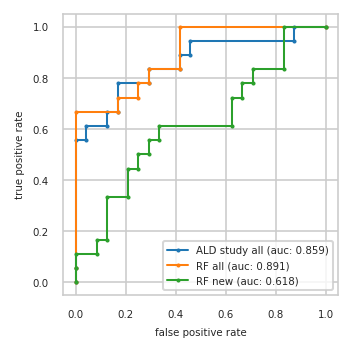

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.556  0.000 0.667  0.000 0.111
3          0.042 0.556  0.167 0.667  0.083 0.111
4          0.042 0.611  0.167 0.722  0.083 0.167
5          0.125 0.611  0.250 0.722  0.125 0.167
6          0.125 0.667  0.250 0.778  0.125 0.333
7          0.167 0.667  0.292 0.778  0.208 0.333
8          0.167 0.778  0.292 0.833  0.208 0.444
9          0.292 0.778  0.417 0.833  0.250 0.444
10         0.292 0.833  0.417 1.000  0.250 0.500
11         0.417 0.833  1.000 1.000  0.292 0.500
12         0.417 0.889    NaN   NaN  0.292 0.556
13         0.458 0.889    NaN   NaN  0.333 0.556
14         0.458 0.944    NaN   NaN  0.333 0.611
15         0.875 0.944    NaN   NaN  0.625 0.611
16         0.875 1.000    NaN   NaN  0.625 0.722
17         1.000 1.000    NaN   NaN  0.667 0.722
18           NaN   NaN    NaN   NaN  0.667 0.778
19           NaN   NaN    NaN   NaN  0.708 0.778
20           NaN   NaN    NaN   NaN  0.708 0.833
21           NaN   NaN    NaN   NaN  0.833 0.833
22           NaN   NaN    NaN   NaN  0.833 1.000
23           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P15086,P02741,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
2,P01597;P04432,Q9GZT8;Q9GZT8-2,P51688
3,P61981,P63104,J3KSJ8;Q9UD71;Q9UD71-2
4,P04075,Q9Y2T3;Q9Y2T3-3,Q96GD0
5,P14174,P61981,Q504Y2
6,C9JF17;P05090,C9JF17;P05090,P31321
7,P00338;P00338-3,P04075,A0A0J9YW36;Q9NZ72;Q9NZ72-2
8,Q9Y2T3;Q9Y2T3-3,P14174,A0A075B7B8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


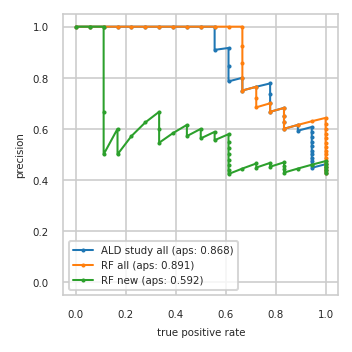

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.459 0.944
6          0.472 0.944     0.500 1.000     0.444 0.889
7          0.486 0.944     0.514 1.000     0.429 0.833
8          0.500 0.944     0.529 1.000     0.441 0.833
9          0.515 0.944     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.452 0.778
12         0.567 0.944     0.600 1.000     0.467 0.778
13         0.586 0.944     0.621 1.000     0.448 0.722
14         0.607 0.944     0.643 1.000     0.464 0.722
15         0.593 0.889     0.630 0.944     0.444 0.667
16         0.615 0.889     0.615 0.889     0.423 0.611
17         0.600 0.833     0.600 0.833     0.440 0.611
18         0.625 0.833     0.625 0.833     0.458 0.611
19         0.652 0.833     0.652 0.833     0.478 0.611
20         0.682 0.833     0.682 0.833     0.500 0.611
21         0.667 0.778     0.667 0.778     0.524 0.611
22         0.700 0.778     0.700 0.778     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.778 0.778     0.722 0.722     0.556 0.556
25         0.765 0.722     0.765 0.722     0.588 0.556
26         0.750 0.667     0.750 0.667     0.562 0.500
27         0.800 0.667     0.800 0.667     0.600 0.500
28         0.786 0.611     0.857 0.667     0.571 0.444
29         0.846 0.611     0.923 0.667     0.615 0.444
30         0.917 0.611     1.000 0.667     0.583 0.389
31         0.909 0.556     1.000 0.611     0.545 0.333
32         1.000 0.556     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


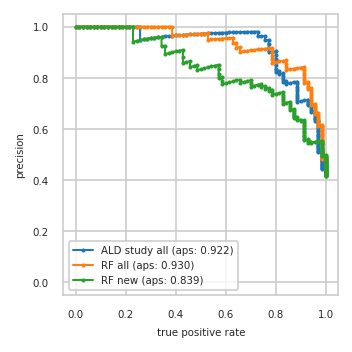

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


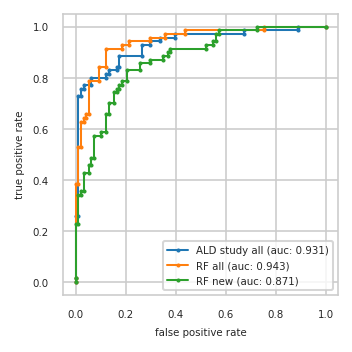

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}